## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest

import warnings
warnings.filterwarnings('ignore')

## Read Data

In [2]:
train_cleaned = pd.read_csv('../data/train_cleaned.csv', index_col='Id')
test_cleaned = pd.read_csv('../data/test_cleaned.csv', index_col='Id')

In [3]:
discrete_features = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
           'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars',
            'Mo Sold', 'Yr Sold']

continuous_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
                       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
                       'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

nominal_features = ['PID', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
                    'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
                    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating',
                    'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type']

ordinal_features = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual',
                    'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
                    'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
                    'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence'
                   ]

## Baseline Regression Model

In [4]:
# Train data

X_train = train_cleaned.drop(['SalePrice', 'PID'], axis=1).copy()
y_train = train_cleaned[['SalePrice']].copy()

# Test data

X_test = test_cleaned.drop(['PID'], axis=1).copy()

In [5]:
X_train.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

In [6]:
X_test.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

In [7]:
# Take all nominal features except PID
reduced_nominal_features = nominal_features[1:]

**Get dummies of train dataset**

In [8]:
X_train = pd.get_dummies(X_train, columns=reduced_nominal_features, drop_first=True)

**Get dummies of test dataset**

In [9]:
X_test = pd.get_dummies(X_test, columns=reduced_nominal_features, drop_first=False)

**Ensure that the number of columns in the train and test datasets are identical and in the same order**

In [10]:
def handle_unequal_train_test_columns(X_train, X_test):
    columns_not_in_test = list(set(X_train.columns).difference(set(X_test.columns)))
    for col in columns_not_in_test:
        X_test[col] = 0
        
    columns_not_in_train = list(set(X_test.columns).difference(set(X_train.columns)))
    X_test.drop(columns_not_in_train, axis=1, inplace=True)
    return X_train[sorted(X_train.columns)], X_test[sorted(X_test.columns)]

In [11]:
X_train, X_test = handle_unequal_train_test_columns(X_train, X_test)

In [12]:
np.array_equal(X_test.columns, X_train.columns)

True

**Linear Regression**

In [13]:
linreg = LinearRegression()

In [14]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
y_train_pred = linreg.predict(X_train)

In [16]:
def r2_adj(y_true, y_preds, p):
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return (1 - (numerator / denominator)).values[0]

In [17]:
def get_regression_metrics(y_true, y_pred, p):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    msle = metrics.mean_squared_log_error(y_true, y_pred)
    mae = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    
    print('Mean squared error      = ', mse)
    print('Root mean squared error = ', rmse)
    print('Mean squared log error  = ', msle)
    print('Median absolute error   = ', mae)
    print('R^2                     = ', r2)
    print('Adjusted R^2            = ', r2a)
    
    return {
        'mse': mse,
        'rmse': rmse,
        'msle': msle,
        'mae': mae,
        'r2': r2,
        'r2_adjusted': r2a
    }

In [18]:
regression_metrics = get_regression_metrics(y_train, y_train_pred, X_train.shape[1])

Mean squared error      =  429148298.93546206
Root mean squared error =  20715.894837912798
Mean squared log error  =  0.02325335395329457
Median absolute error   =  10988.316760100424
R^2                     =  0.9314647305188853
Adjusted R^2            =  0.9236105508758705


In [19]:
regression_metrics['rmse']

20715.894837912798

In [20]:
# RMSE for all regression

models_rmse = {}
models_rmse['linreg'] = (-cross_val_score(linreg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [21]:
scores = cross_val_score(LinearRegression(), X_train, y_train, cv=5)
scores.mean()

-698126660.4120839

In [22]:
X_test_indices = X_test.index

In [23]:
y_test_pred = linreg.predict(X_test)

In [24]:
linreg.coef_

array([[-8.95457310e+05, -8.95457900e+05,  5.67191873e+00,
         1.31200185e+03, -4.39843729e+03, -3.83943579e+03,
         2.49601868e+04,  7.53043629e+11,  1.34187858e+03,
         6.71890821e+03, -3.81627340e+03,  4.13188720e+03,
         3.41421215e+03,  5.72960299e+02,  2.55206922e+03,
         3.26689098e+12,  3.26689098e+12,  3.26689098e+12,
        -2.83484409e+02,  6.71652888e+02, -3.95056715e+03,
         6.31326430e+03,  1.20930151e+04,  2.06099097e+04,
         2.24904947e+04, -4.20465502e+03,  3.59532180e+03,
         5.86984018e+03, -1.29110754e+03,  7.95793247e+03,
         8.07997194e+03,  4.39786497e+04,  4.32217930e+03,
        -2.16971834e+04,  1.44484898e+04,  1.42613832e+04,
        -1.51537901e+03,  3.71230316e+00, -1.84694369e+03,
         7.73641400e+03, -2.25333817e+04, -3.15810022e+04,
         5.40141127e+03,  1.40637115e+04,  1.02843191e+04,
        -1.29963354e+04, -2.41332491e+04, -9.72190115e+03,
        -1.15853722e+04, -3.43580779e+04, -1.38451160e+0

In [25]:
y_test_pred = [i[0] for i in y_test_pred.tolist()]

In [26]:
def make_and_get_submissions_file(X_test_indices, y_test_pred, file_name):
    submissions = pd.DataFrame({'Id': X_test_indices, 'SalePrice': y_test_pred})
    submissions.set_index('Id', inplace=True)
    submissions.sort_index(inplace=True)
    submissions.to_csv('../data/{}.csv'.format(file_name))
    
    return submissions

In [27]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_baseline_regression')

## Scaling and Regularization

In [28]:
# Train data

X_train = train_cleaned.drop(['SalePrice', 'PID'], axis=1).copy()
y_train = train_cleaned[['SalePrice']].copy()

# Test data

X_test = test_cleaned.drop(['PID'], axis=1).copy()

In [29]:
nominal_features = ['PID', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
                    'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
                    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating',
                    'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type']

In [30]:
# Take all nominal features except PID
reduced_nominal_features = nominal_features[1:]

**Get dummies for nominal features**

In [31]:
X_train = pd.get_dummies(X_train, columns=reduced_nominal_features, drop_first=True)

In [32]:
X_test = pd.get_dummies(X_test, columns=reduced_nominal_features, drop_first=False)

In [33]:
X_train, X_test = handle_unequal_train_test_columns(X_train, X_test)
X_train_columns = X_train.columns
X_test_columns = X_test.columns

**Standardization of features**

In [34]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

**Lasso Regression with All Features** 

In [35]:
# Cross Validation
optimal_lasso = LassoCV(n_alphas=500, cv=10) # uses 10-fold

In [36]:
# Model Fitting and Evaluation
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_train, y_train)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso_scores.mean()

0.9111559457143654

In [37]:
(-cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

23432.199292472586

In [38]:
models_rmse['lasso'] = (-cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [39]:
y_test_pred = lasso.predict(X_test)

In [40]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_lasso_regression_all_features')

<StemContainer object of 3 artists>

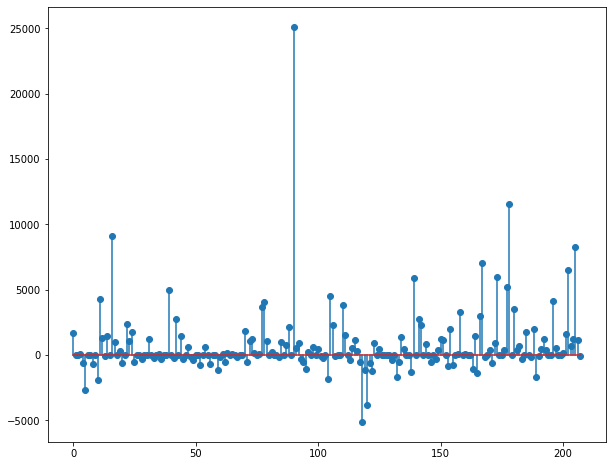

In [41]:
plt.figure(figsize=(10, 8))
plt.stem(lasso.coef_)

In [42]:
(lasso.coef_ != 0).nonzero()[0]

array([  0,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  16,  17,
        19,  20,  22,  23,  24,  25,  28,  31,  33,  35,  36,  38,  39,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  52,  54,  56,  59,
        60,  61,  62,  63,  65,  67,  70,  71,  72,  73,  74,  76,  77,
        78,  79,  81,  84,  85,  87,  88,  90,  91,  92,  93,  94,  95,
        96,  98, 100, 101, 102, 104, 105, 106, 107, 109, 110, 111, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 130, 132,
       133, 134, 135, 138, 139, 141, 142, 144, 146, 148, 149, 150, 151,
       153, 154, 155, 156, 157, 158, 160, 163, 164, 165, 166, 167, 168,
       170, 171, 172, 173, 176, 177, 178, 180, 181, 182, 183, 185, 187,
       188, 189, 190, 191, 192, 193, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207])

In [43]:
X_test_columns[(lasso.coef_ != 0).nonzero()[0]]

Index(['1st Flr SF', 'Alley_None', 'Alley_Pave', 'Bedroom AbvGr',
       'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bsmt Cond', 'Bsmt Exposure',
       'Bsmt Full Bath', 'Bsmt Half Bath',
       ...
       'Sale Type_WD ', 'Screen Porch', 'Street_Pave', 'TotRms AbvGrd',
       'Total Bsmt SF', 'Utilities', 'Wood Deck SF', 'Year Built',
       'Year Remod/Add', 'Yr Sold'],
      dtype='object', length=148)

In [44]:
lasso.coef_[(lasso.coef_ != 0).nonzero()[0]]

array([ 1.68618374e+03,  5.80195180e+01, -5.75663365e+02, -2.67562458e+03,
       -6.55812234e+00, -6.53248322e+02, -1.90691344e+03,  4.25726467e+03,
        1.27201452e+03, -4.77959112e+01,  1.45539617e+03,  9.12568508e+03,
        9.87559151e+02,  2.95355025e+02, -5.90213621e+02,  2.38526473e+03,
        1.05321533e+03,  1.77529134e+03, -5.30775313e+02, -2.78791945e+02,
        1.25299090e+03, -2.37430386e+02,  4.77492599e+01, -3.29900344e+02,
       -7.54367183e+00,  4.96537518e+03, -1.97845955e+02,  2.71945937e+03,
        1.65392522e+01,  1.47238379e+03, -3.28479081e+02, -1.98478004e+01,
        6.05982840e+02, -1.83466524e+02, -3.65162429e+02, -7.34118559e+02,
        5.99015334e+02, -6.90874594e+02, -1.18101415e+03, -1.77506637e+02,
        1.02486550e+02, -5.47334971e+02,  1.48026739e+02,  4.15773625e+01,
       -1.86289377e+02,  1.83630022e+03, -5.67094669e+02,  1.05679312e+03,
        1.23201806e+03,  1.51700124e+02,  9.01545524e+01,  3.66807626e+03,
        4.04346959e+03,  

**Ridge Regression**

In [45]:
# Cross Validation
optimal_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

In [46]:
# Model Fitting and Evaluation
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train, y_train)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge_scores.mean()

0.9106785885882852

In [47]:
(-cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

23521.49687173972

In [48]:
models_rmse['ridge'] = (-cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [49]:
y_test_pred = ridge.predict(X_test)

In [50]:
y_test_pred = y_test_pred.reshape(-1)

In [51]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_ridge_regression_all_features')

**Elastic Net Regression**

In [52]:
optimal_enet = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10,
                            verbose=1)

In [53]:
optimal_enet.fit(X_train, y_train)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet.fit(X_train, y_train)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)
np.mean(enet_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.9111628049099003

In [54]:
(-cross_val_score(enet, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

23431.392750888008

In [55]:
models_rmse['enet'] = (-cross_val_score(enet, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [56]:
y_test_pred = enet.predict(X_test)

In [57]:
y_test_pred = y_test_pred.reshape(-1)

In [58]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_enet_regression_all_features')

In [59]:
models_rmse

{'linreg': 667485266.4907762,
 'lasso': 23432.199292472586,
 'ridge': 23521.49687173972,
 'enet': 23431.392750888008}

## Feature Engineering

In [60]:
# Train data

X_train = train_cleaned.drop(['SalePrice'], axis=1).copy()
y_train = train_cleaned[['SalePrice']].copy()

# Test data

X_test = test_cleaned.drop([], axis=1).copy()

**Explore discrete, continuous, and ordinal variables with high correlation with SalePrice**

In [61]:
subset_features = discrete_features + continuous_features + ordinal_features + ['SalePrice']

In [62]:
train_cleaned[subset_features].corr()['SalePrice'].sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.803276
Gr Liv Area        0.721925
Exter Qual         0.714759
Kitchen Qual       0.693022
Total Bsmt SF      0.668507
1st Flr SF         0.654694
Garage Area        0.653894
Garage Cars        0.647460
Bsmt Qual          0.616228
Year Built         0.572423
Garage Finish      0.559005
Year Remod/Add     0.549903
Full Bath          0.538732
Fireplace Qu       0.537845
Mas Vnr Area       0.520501
TotRms AbvGrd      0.511007
Fireplaces         0.473933
Heating QC         0.458679
BsmtFin SF 1       0.446922
Bsmt Exposure      0.427511
BsmtFin Type 1     0.353104
Lot Frontage       0.350892
Open Porch SF      0.330726
Wood Deck SF       0.329865
Lot Area           0.303137
Paved Drive        0.290136
Bsmt Full Bath     0.285615
Garage Qual        0.285459
Half Bath          0.278854
Garage Cond        0.264949
Garage Yr Blt      0.258078
2nd Flr SF         0.251325
Electrical         0.246662
Bsmt Cond          0.224596
Bsmt Unf SF        0

In [63]:
train_cleaned[subset_features].corr()['SalePrice'][train_cleaned.corr()['SalePrice'] > 0.5].sort_values(ascending=False)

SalePrice         1.000000
Overall Qual      0.803276
Gr Liv Area       0.721925
Exter Qual        0.714759
Kitchen Qual      0.693022
Total Bsmt SF     0.668507
1st Flr SF        0.654694
Garage Area       0.653894
Garage Cars       0.647460
Bsmt Qual         0.616228
Year Built        0.572423
Garage Finish     0.559005
Year Remod/Add    0.549903
Full Bath         0.538732
Fireplace Qu      0.537845
Mas Vnr Area      0.520501
TotRms AbvGrd     0.511007
Name: SalePrice, dtype: float64

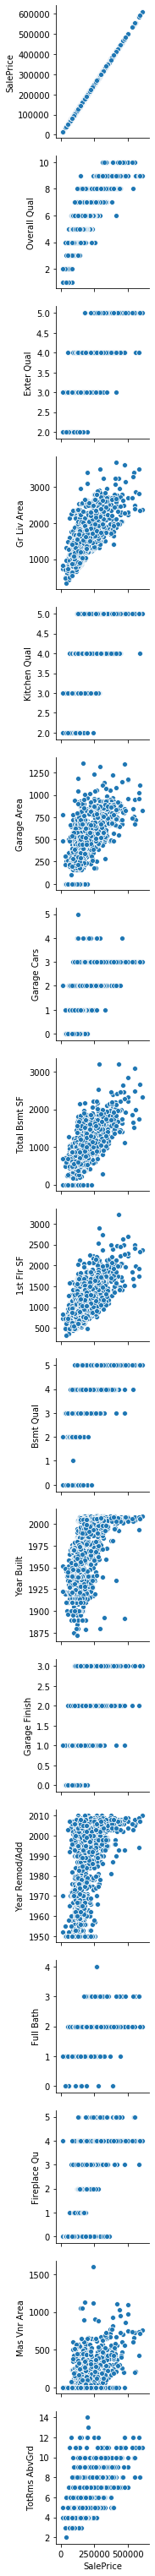

In [64]:
sns.pairplot(train_cleaned, y_vars=['SalePrice', 'Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 
                                    'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Bsmt Qual', 
                                    'Year Built', 'Garage Finish', 'Year Remod/Add', 'Full Bath', 
                                    'Fireplace Qu', 'Mas Vnr Area', 'TotRms AbvGrd'],
             x_vars=['SalePrice'])

In [65]:
chosen_numeric_and_ordinal_features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'TotRms AbvGrd']

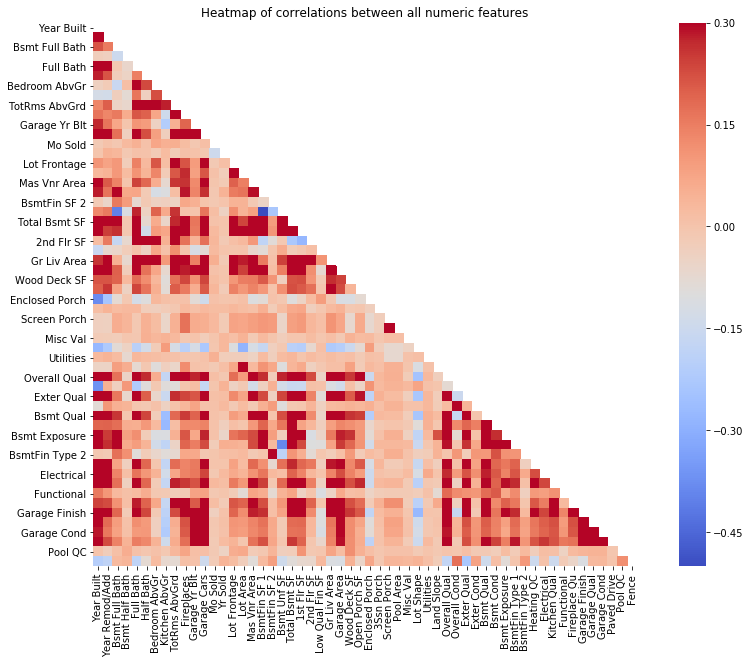

In [66]:
corr = X_train[discrete_features + continuous_features + ordinal_features].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap='coolwarm')
plt.title('Heatmap of correlations between all numeric features');

# plt.figure(figsize=(15,15))
# sns.heatmap(X_train[discrete_features + continuous_features + ordinal_features].corr(), cmap='coolwarm')

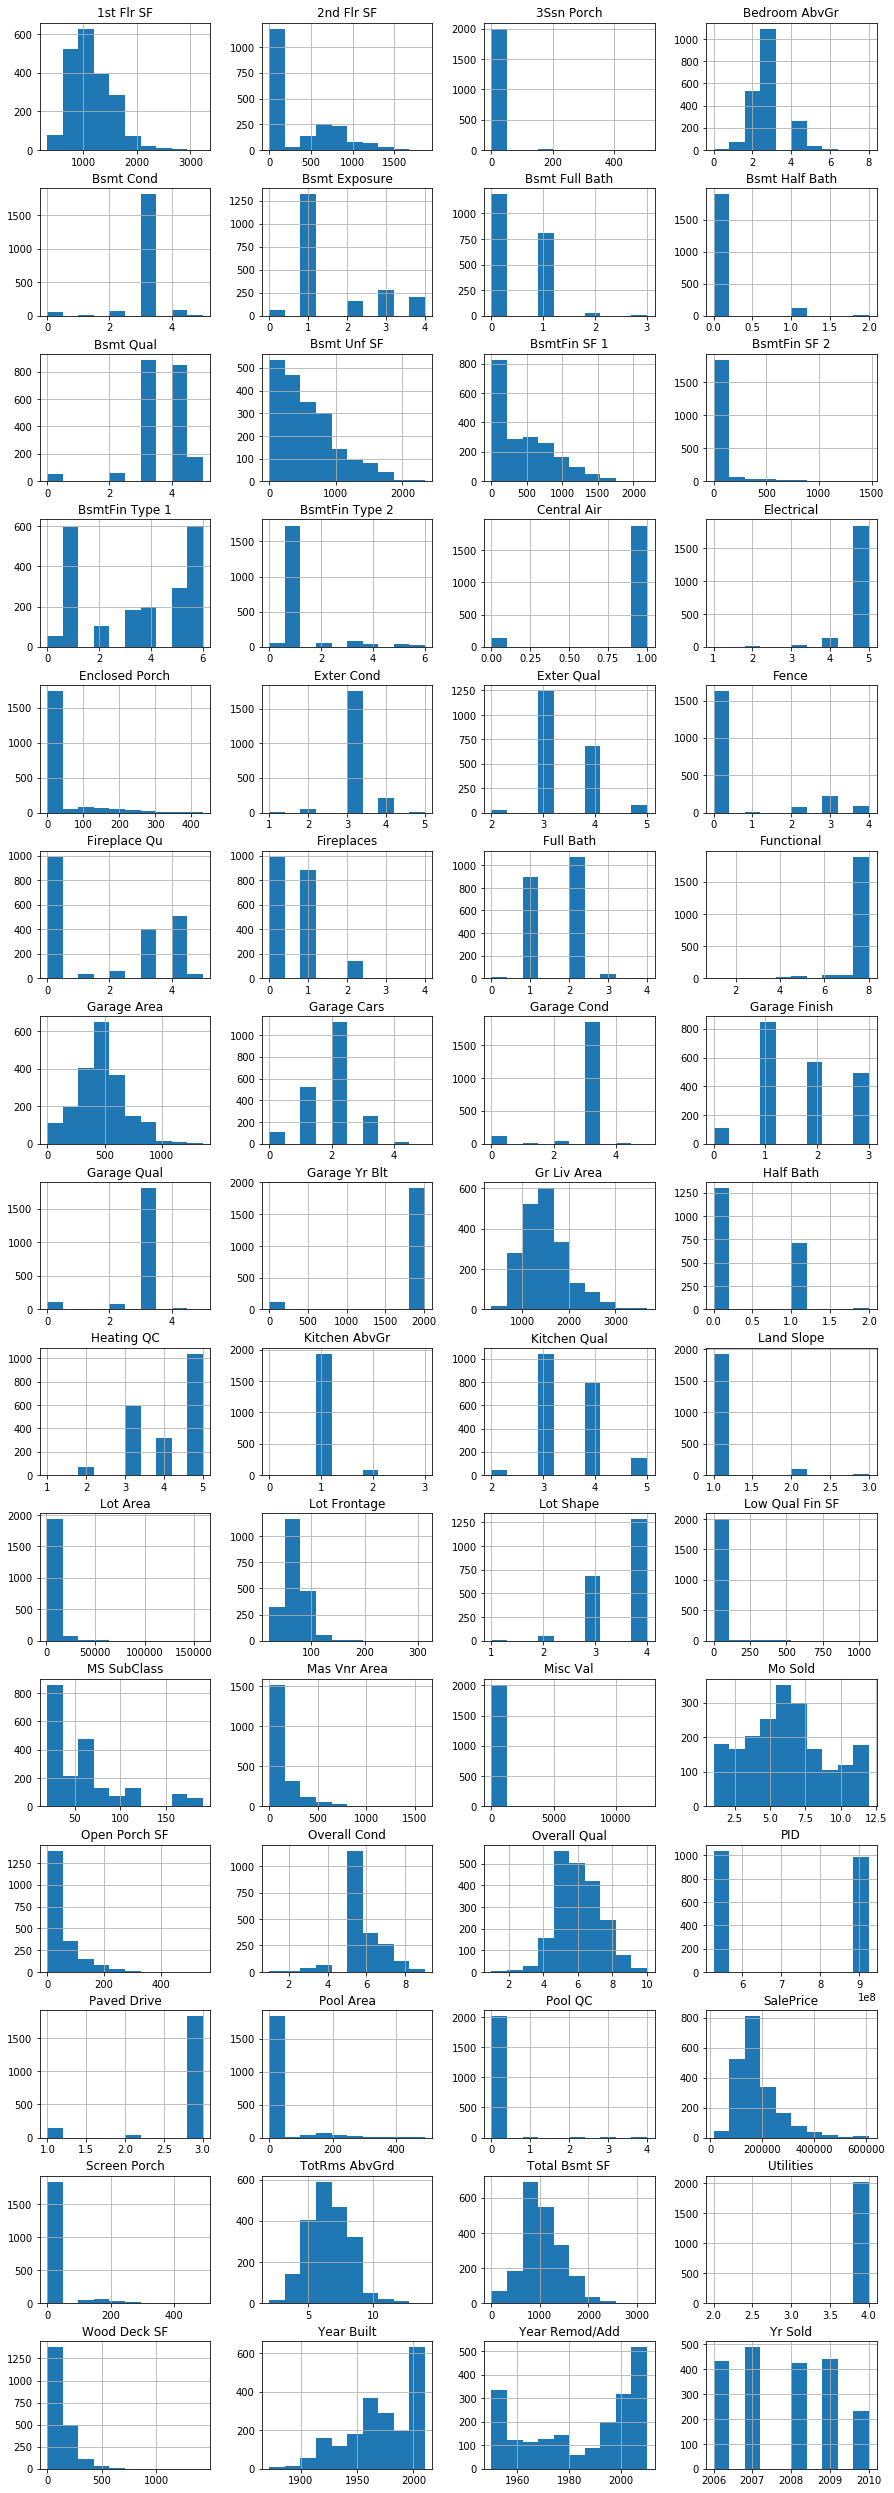

In [67]:
train_cleaned.hist(figsize=(15, 45), layout=(-1,4));

**Nominal Features**

In [68]:
# set(nominal_features).difference(set(train_cleaned.corr().columns))

In [69]:
f_values, p_values = f_classif(X_train[nominal_features].apply(LabelEncoder().fit_transform), y_train)
p_values

array([9.32013984e-005, 8.25167634e-001, 2.69546815e-022, 1.19968216e-209,
       2.83766944e-001, 2.16513112e-003, 7.61584934e-001, 1.69933194e-004,
       7.12129414e-001, 5.66258086e-014, 2.98620507e-001, 6.01538789e-002,
       3.26550234e-003, 6.65840166e-010, 5.80154133e-001, 4.84961562e-001,
       7.42153506e-009, 9.19574687e-023, 1.39981086e-014, 4.91551746e-017,
       1.08055179e-022, 9.98258854e-001, 6.88820466e-001])

In [70]:
np.where(p_values < 0.05)[0]

array([ 0,  2,  3,  5,  7,  9, 12, 13, 16, 17, 18, 19, 20])

In [71]:
chosen_nominal_features = X_train[nominal_features].iloc[:, np.where(p_values < 0.05)[0]].columns.tolist()

In [72]:
X_train = X_train[chosen_numeric_and_ordinal_features + chosen_nominal_features]

In [73]:
X_test = X_test[chosen_numeric_and_ordinal_features + chosen_nominal_features]

**Get dummies of train dataset**

In [74]:
X_train = pd.get_dummies(X_train, columns=chosen_nominal_features, drop_first=True)

**Get dummies of test dataset**

In [75]:
X_test = pd.get_dummies(X_test, columns=chosen_nominal_features, drop_first=False)

**Ensure that the number of columns in the train and test datasets are identical and in the same order**

In [76]:
X_train, X_test = handle_unequal_train_test_columns(X_train, X_test)

In [77]:
X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [78]:
np.array_equal(X_test.columns, X_train.columns)

True

**Linear Regression**

In [79]:
linreg = LinearRegression()

In [80]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
y_train_pred = linreg.predict(X_train)

In [82]:
regression_metrics = get_regression_metrics(y_train, y_train_pred, X_train.shape[1])

Mean squared error      =  2.2334957133681306e-16
Root mean squared error =  1.4944884453779262e-08
Mean squared log error  =  1.1964417938426437e-26
Median absolute error   =  7.101334631443024e-09
R^2                     =  1.0
Adjusted R^2            =  1.0


In [83]:
models_rmse = {}
models_rmse['linreg'] = (-cross_val_score(linreg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [84]:
scores = cross_val_score(linreg, X_train, y_train, cv=5)
scores.mean()

0.8587008988592422

In [85]:
X_test_indices = X_test.index

In [86]:
y_test_pred = linreg.predict(X_test)

In [87]:
linreg.coef_

array([[   12.42882144,   377.43027535, -6155.71112843, ...,
           24.24234148,   189.14805522,   270.91871184]])

In [88]:
y_test_pred = [i[0] for i in y_test_pred.tolist()]

In [89]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_linear_regression_feature_engineered')

**Standardization of features**

In [90]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

**Lasso Regression** 

In [91]:
# Cross Validation
optimal_lasso = LassoCV(n_alphas=500, cv=10) # uses 10-fold

In [92]:
# Model Fitting and Evaluation
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_train, y_train)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso_scores.mean()

0.8481200263534096

In [93]:
models_rmse['lasso'] = (-cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [94]:
y_test_pred = lasso.predict(X_test)

In [95]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_lasso_regression_feature_engineered')

<StemContainer object of 3 artists>

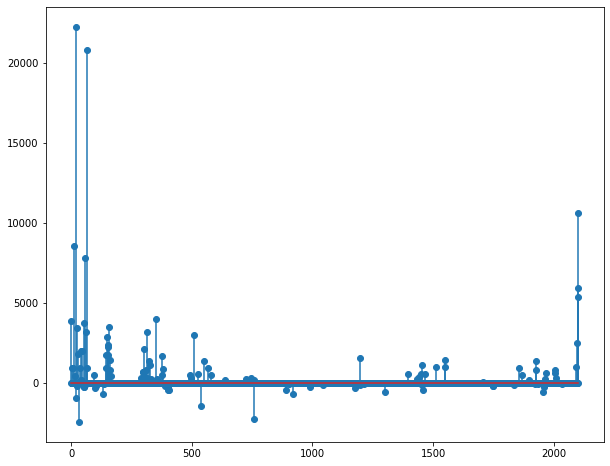

In [96]:
plt.figure(figsize=(10, 8))
plt.stem(lasso.coef_)

In [97]:
(lasso.coef_ != 0).nonzero()[0]

array([   0,    4,   10,   14,   17,   19,   21,   24,   26,   27,   34,
         37,   40,   41,   43,   47,   53,   54,   55,   56,   60,   62,
         64,   65,   94,  101,  103,  106,  133,  137,  143,  144,  147,
        152,  153,  154,  155,  156,  161,  163,  164,  289,  294,  299,
        300,  302,  303,  305,  312,  313,  314,  315,  317,  322,  324,
        328,  329,  330,  352,  357,  358,  377,  378,  381,  390,  401,
        402,  403,  405,  494,  497,  510,  528,  539,  551,  567,  578,
        636,  723,  746,  756,  757,  892,  902,  920,  992, 1019, 1046,
       1175, 1193, 1196, 1199, 1215, 1301, 1396, 1434, 1440, 1450, 1453,
       1455, 1457, 1465, 1513, 1550, 1551, 1709, 1725, 1746, 1747, 1748,
       1749, 1801, 1834, 1857, 1869, 1899, 1923, 1926, 1927, 1935, 1956,
       1960, 1965, 1970, 2006, 2007, 2008, 2034, 2092, 2095, 2100, 2101,
       2102])

In [98]:
X_test_columns[(lasso.coef_ != 0).nonzero()[0]]

Index(['1st Flr SF', 'Condition 2_PosA', 'Foundation_PConc', 'Garage Area',
       'Garage Type_BuiltIn', 'Garage Type_Detchd', 'Gr Liv Area',
       'Heating_OthW', 'Land Contour_HLS', 'Land Contour_Low',
       ...
       'PID_916382100', 'PID_921128050', 'PID_921201060', 'PID_921205050',
       'PID_923225260', 'Roof Matl_WdShngl', 'Roof Style_Hip', 'Total Bsmt SF',
       'Year Built', 'Year Remod/Add'],
      dtype='object', length=133)

In [99]:
lasso.coef_[(lasso.coef_ != 0).nonzero()[0]]

array([ 3.83262403e+03,  9.28677859e+02,  9.08534073e+02,  8.55415464e+03,
        4.09787270e+02, -9.83490389e+02,  2.22451043e+04, -1.88246989e+02,
        3.43894483e+03,  1.80310762e+03, -2.47031124e+03,  9.13858435e+02,
        1.81427200e+02,  1.79646994e+02,  1.97699355e+03,  1.94479208e+03,
       -2.55338972e+02, -2.68756301e+02,  3.73130839e+03,  7.76937735e+03,
       -8.52025500e+01,  3.16872734e+03,  8.94659917e+02,  2.07682522e+04,
        4.58898119e+02, -3.13518489e+02, -2.39544894e+02, -2.76153519e+01,
       -6.91809998e+02, -8.37675860e+01,  8.92749552e+02,  1.73609656e+03,
        2.83492103e+03,  1.69536005e+03,  2.33048161e+03,  1.73490806e+01,
        2.19175919e+03,  3.45857847e+03,  1.41577501e+03,  7.95774180e+02,
        3.97564277e+02,  3.13066206e+02,  1.75950888e+02,  6.73729795e+02,
        6.32580327e+02,  2.08819329e+03,  3.72196770e+02,  7.23416953e+02,
        7.70085921e+02,  2.55986915e+02,  1.41943944e+02,  3.15677047e+03,
        8.29697336e+00,  

**Ridge Regression**

In [100]:
# Cross Validation
optimal_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

In [101]:
# Model Fitting and Evaluation
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train, y_train)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge_scores.mean()

0.8214846152824327

In [102]:
models_rmse['ridge'] = (-cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [103]:
y_test_pred = ridge.predict(X_test)

In [104]:
y_test_pred = y_test_pred.reshape(-1)

In [105]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_ridge_regression_feature_engineered')

**Elastic Net Regression**

In [106]:
optimal_enet = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10,
                            verbose=1)

In [107]:
optimal_enet.fit(X_train, y_train)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet.fit(X_train, y_train)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)
np.mean(enet_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.......................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  6.3min finished


0.8481215232186278

In [108]:
models_rmse['enet'] = (-cross_val_score(enet, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')).mean()

In [109]:
y_test_pred = enet.predict(X_test)

In [110]:
y_test_pred = y_test_pred.reshape(-1)

In [111]:
submissions = make_and_get_submissions_file(X_test_indices, y_test_pred, 'submissions_enet_regression_feature_engineered')

In [112]:
models_rmse

{'linreg': 29638.750904062053,
 'lasso': 30728.218799374685,
 'ridge': 33353.00763231608,
 'enet': 30728.015128476552}